In [1]:
import os
os.chdir('/data/l989o/deployed/a')
import sys
if '/data/l989o/a' in sys.path:
    sys.path.remove('/data/l989o/a')
print(os.getcwd())
import numpy as np
print(np.random.randint(0, 5))
from jupy import *

/data/l989o/deployed/a
4


In [2]:
from data import RawCountDataset
import torch
import matplotlib.pyplot as plt
params = {"ytick.color" : "k",
          "xtick.color" : "k",
          'text.color' : 'k',
          "axes.labelcolor" : "k",
          "axes.edgecolor" : "k"}
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams.update(params)

True
<KeysViewHDF5 ['count', 'maximum', 'mean', 'sum', 'variance']>


In [3]:
import os

os.makedirs('data/spatial_uzh_processed/a/', exist_ok=True)


def plt_show(plt, filename, dpi=72):
    f = os.path.join('data/spatial_uzh_processed/a', filename)
    print('saving figure in', f)
    plt.savefig(f, dpi=dpi, bbox_inches='tight')
    plt.show()


train 226
cells.shape = torch.Size([516890]), ome_indices.shape = torch.Size([516890]), cell_ids.shape = torch.Size([516890])
[(1, 56817),
 (2, 2513),
 (3, 906),
 (4, 637),
 (5, 649),
 (6, 714),
 (7, 754),
 (8, 835),
 (9, 923)]
saving figure in data/spatial_uzh_processed/a/cells_area_cutoff.png


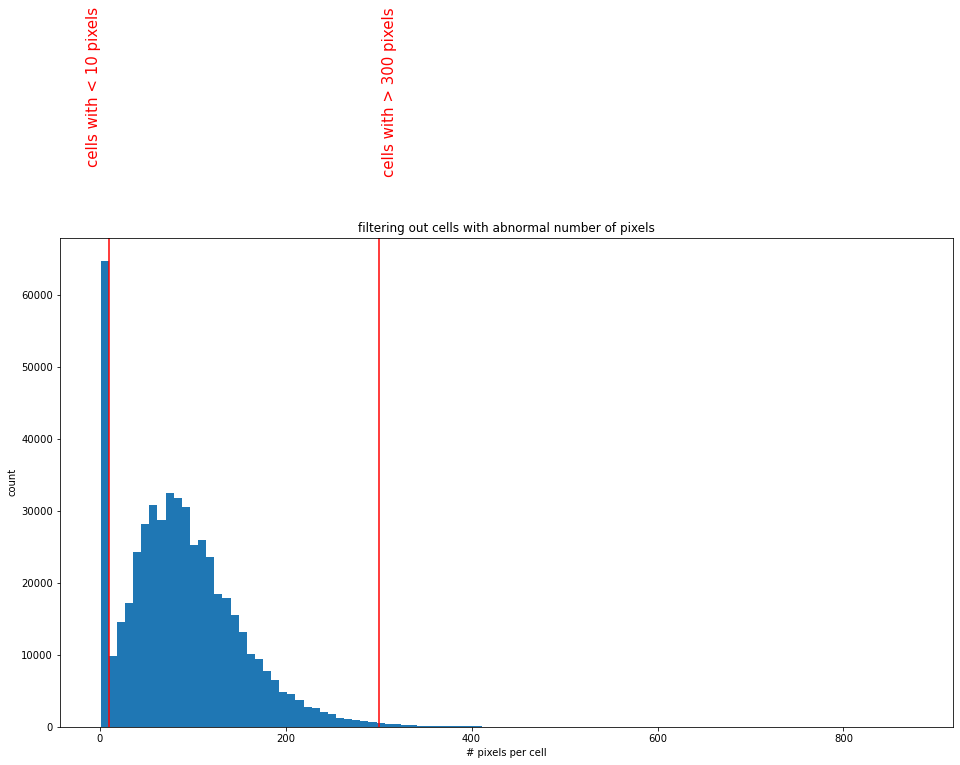

saving figure in data/spatial_uzh_processed/a/cells_small_area.png


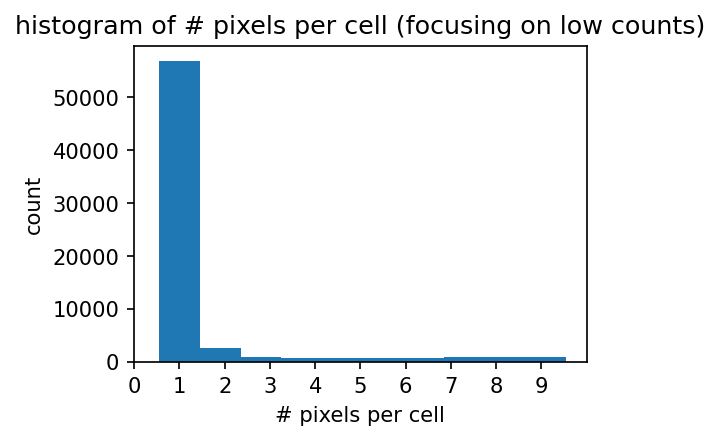

saving figure in data/spatial_uzh_processed/a/cells_area_after_filtering.png


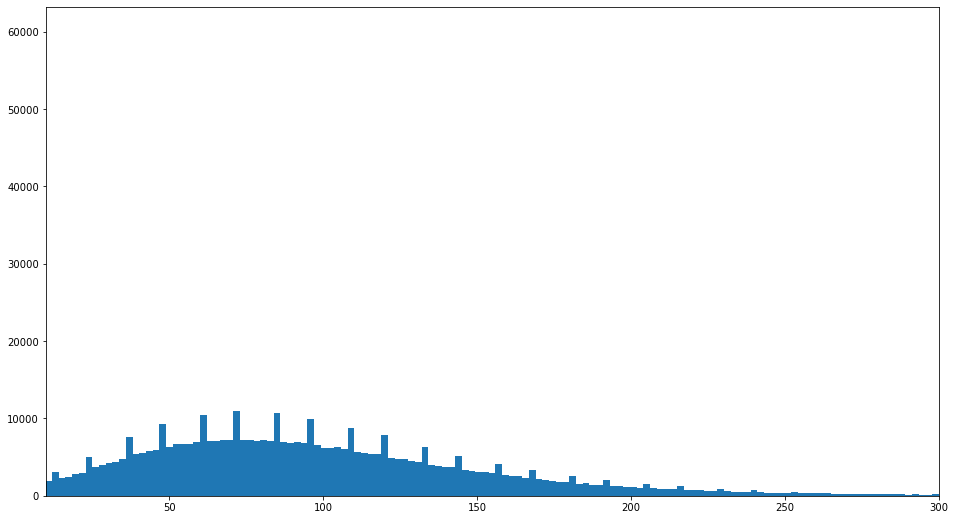

tensor([ 41010, 118474, 171838, 304805, 305159])
saving figure in data/spatial_uzh_processed/a/big_cells.png


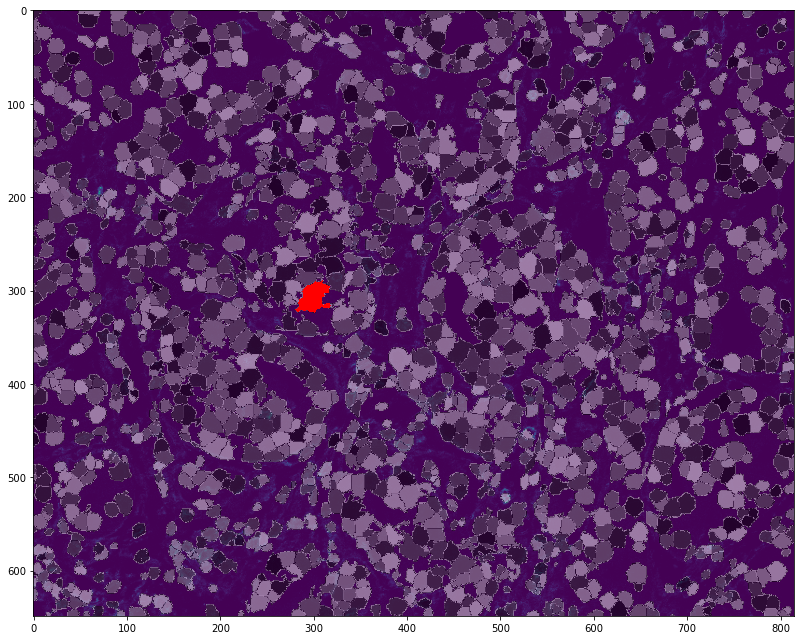

validation 113
cells.shape = torch.Size([253530]), ome_indices.shape = torch.Size([253530]), cell_ids.shape = torch.Size([253530])
[(1, 28269),
 (2, 1223),
 (3, 398),
 (4, 301),
 (5, 262),
 (6, 315),
 (7, 365),
 (8, 378),
 (9, 411)]
saving figure in data/spatial_uzh_processed/a/cells_area_cutoff.png


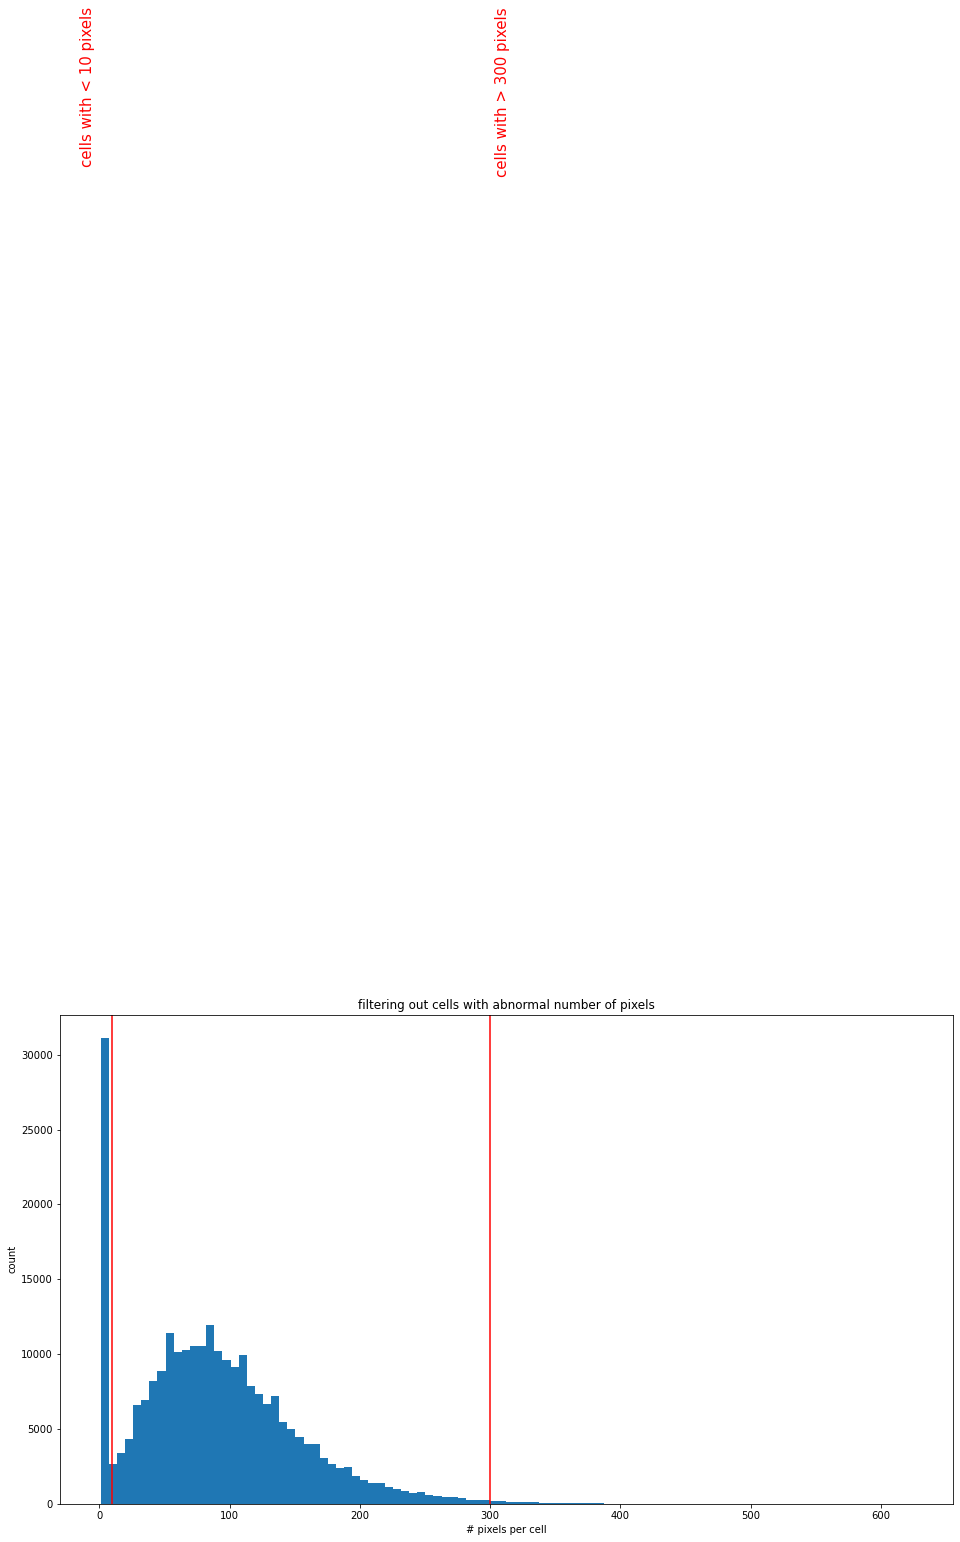

saving figure in data/spatial_uzh_processed/a/cells_small_area.png


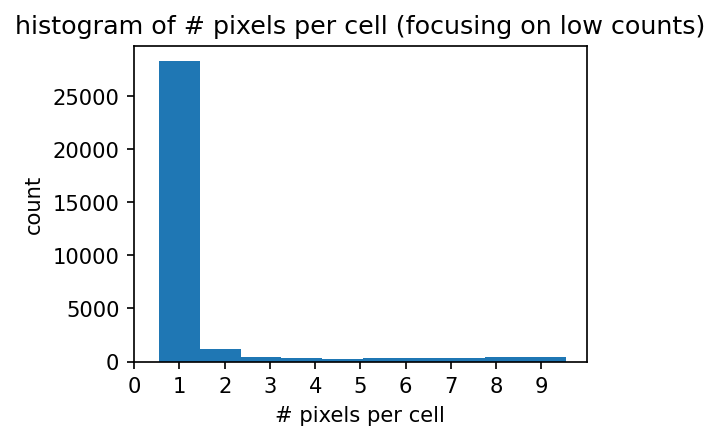

saving figure in data/spatial_uzh_processed/a/cells_area_after_filtering.png


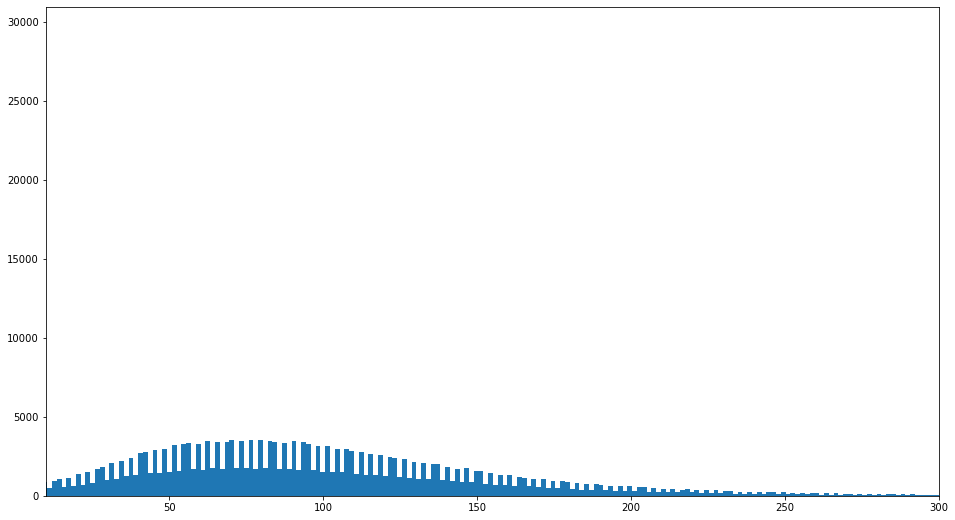

tensor([], dtype=torch.int64)
test 113
cells.shape = torch.Size([252401]), ome_indices.shape = torch.Size([252401]), cell_ids.shape = torch.Size([252401])
[(1, 27536),
 (2, 1143),
 (3, 407),
 (4, 289),
 (5, 289),
 (6, 356),
 (7, 385),
 (8, 394),
 (9, 422)]
saving figure in data/spatial_uzh_processed/a/cells_area_cutoff.png


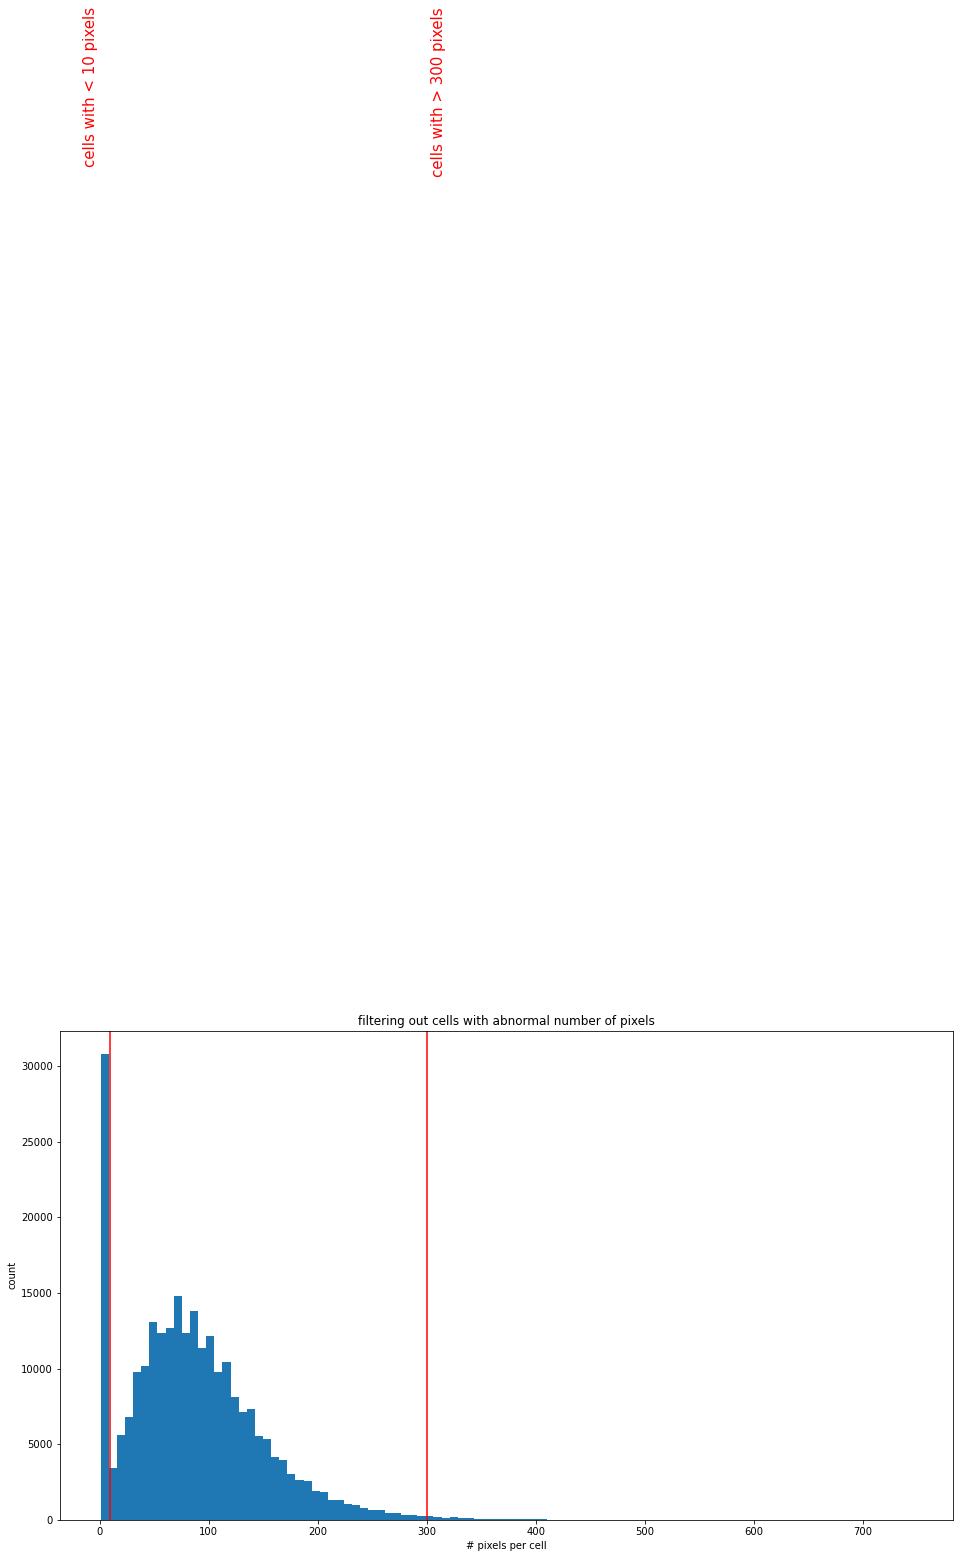

saving figure in data/spatial_uzh_processed/a/cells_small_area.png


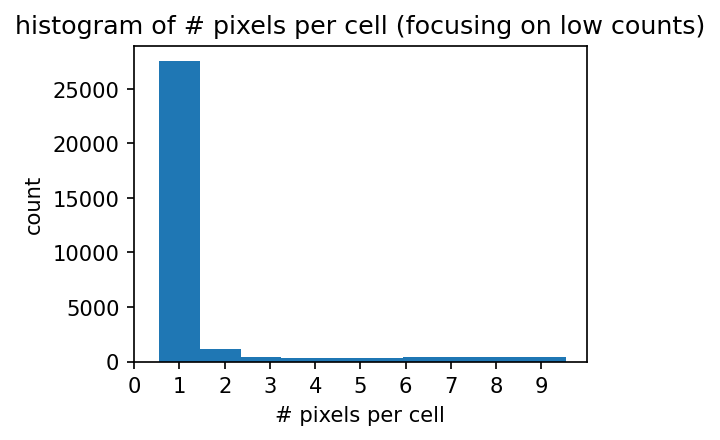

saving figure in data/spatial_uzh_processed/a/cells_area_after_filtering.png


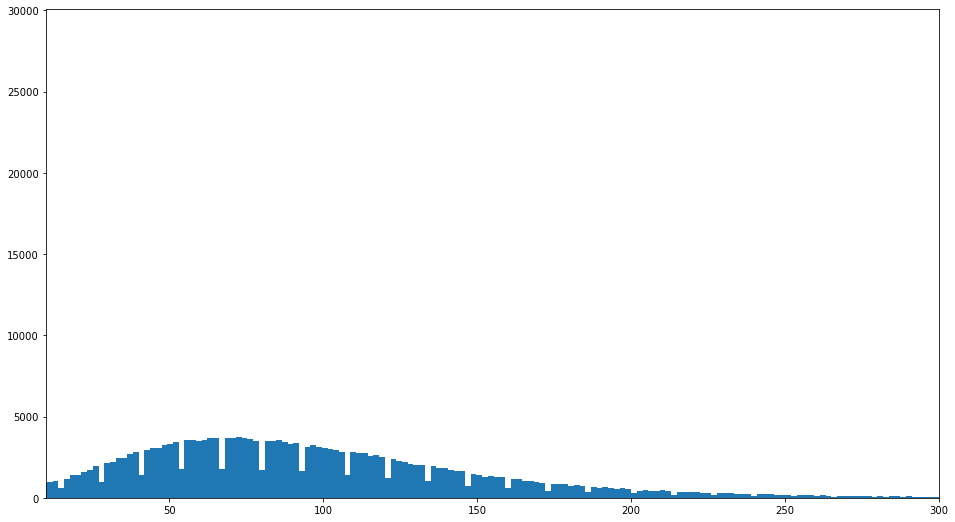

tensor([121002])
saving figure in data/spatial_uzh_processed/a/big_cells.png


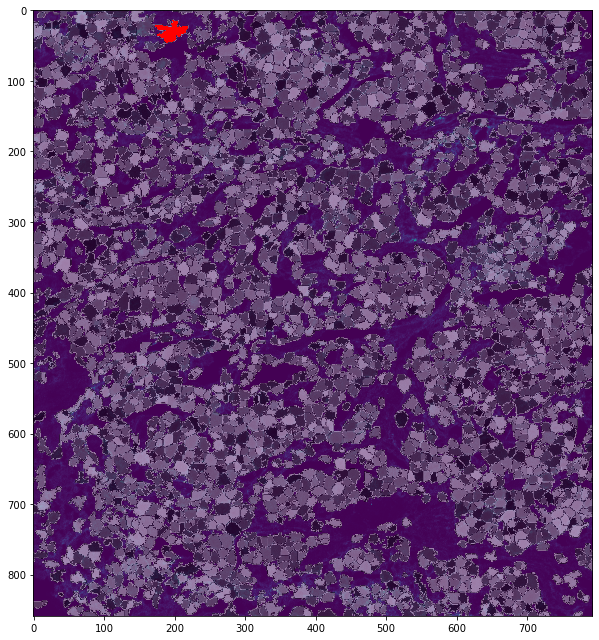

In [4]:
for SPLIT in ['train', 'validation', 'test']:
    from data import AreaDataset
    ds = AreaDataset(SPLIT)
    ome_filenames = ds.filenames
    print(SPLIT, len(ome_filenames))
    list_of_cells = []
    list_of_ome_filenames = []
    list_of_ome_indices = []
    list_of_cell_ids = []
    for i, x in enumerate(ds):
        x = torch.tensor(x[1:])
        list_of_cells.append(x)
        list_of_ome_filenames.extend([ome_filenames[i]] * len(x))
        list_of_ome_indices.append(torch.tensor([i] * len(x)))
        list_of_cell_ids.append(torch.tensor(list(range(1, len(x) + 1))))
    cells = torch.cat(list_of_cells)
    ome_indices = torch.cat(list_of_ome_indices)
    cell_ids = torch.cat(list_of_cell_ids)
    print(f'cells.shape = {cells.shape}, ome_indices.shape = {ome_indices.shape}, cell_ids.shape = {cell_ids.shape}')

    small_cells = cells[cells < 10]
    from pprint import pprint
    pprint(list(zip(*np.unique(small_cells, return_counts=True))))

    import matplotlib.pyplot as plt
    plt.figure(figsize=(16, 9))
    plt.hist(cells.numpy(), bins=100)
    a = 10
    b = 300
    plt.axvline(x=a, c='r')
    plt.axvline(x=b, c='r')
    plt.text(a - 25, 100000,f'cells with < {a} pixels',rotation=90, c='r', verticalalignment='top', fontsize=15)
    plt.text(b + 4, 100000,f'cells with > {b} pixels',rotation=90, c='r', verticalalignment='top', fontsize=15)
    plt.xlabel('# pixels per cell')
    plt.ylabel('count')
    plt.title('filtering out cells with abnormal number of pixels')
    plt_show(plt, 'cells_area_cutoff.png')

    import matplotlib.pyplot as plt
    plt.figure(figsize=(4, 3), dpi=152)
    plt.hist(cells.numpy()[cells <= a], bins=a, align='left')
    plt.xlim([0, a])
    plt.xticks(list(range(a)))
    plt.xlabel('# pixels per cell')
    plt.ylabel('count')
    plt.title('histogram of # pixels per cell (focusing on low counts)')
    plt.tight_layout()
    plt_show(plt, 'cells_small_area.png', dpi=152)

    is_ok = (a <= cells) & (cells <= b)
    import pickle
    f = os.path.join('data/spatial_uzh_processed/a', f'ok_cells_{SPLIT}.npy')
    is_ok.numpy()
    d = {'list_of_cells': list_of_cells,
         'list_of_ome_indices': list_of_ome_indices,
         'list_of_ome_filenames': list_of_ome_filenames,
         'list_of_cell_ids': list_of_cell_ids,
         'cell_is_ok': is_ok.numpy()}
    pickle.dump(d, open(f, 'wb'))
    filtered_cells = cells[is_ok]

    plt.figure(figsize=(16, 9))
    plt.hist(cells.numpy(), bins=400)
    plt.xlim([a, b])
    plt_show(plt, 'cells_area_after_filtering.png')

    large_cells = torch.nonzero(cells >= 700, as_tuple=True)[0]
    print(large_cells)

    from data import OmeDataset, MasksDataset
    import matplotlib
    import colorsys
    import random

    ome_ds = OmeDataset(SPLIT)
    masks_ds = MasksDataset(SPLIT)
    for index in large_cells:
        ome_index = ome_indices[index]
        cell_id = cell_ids[index]
        ome = ome_ds[ome_index]
        masks = masks_ds[ome_index]
        masks_all = masks.copy()
        masks_all[masks > 0] = 1

        masks_big = masks.copy()
        masks_big[masks != cell_id.item()] = 0
        masks_big[masks == cell_id.item()] = 1

        channel = 20
        plt.figure(figsize=(16, 9))
        plt.imshow(ome[:, :, channel])


        n_grays = 10000
        g = np.random.random(n_grays)
        colors = [(g[i], g[i], g[i], 0.5) for i in range(n_grays)]
        colors[0] = (0., 0., 0., 0.)
        cmap_gray = matplotlib.colors.LinearSegmentedColormap.from_list('random gray', colors, N=n_grays)
        plt.imshow(masks, cmap_gray)

        cmap_list = [(0., 0., 0., 0.), (1., 0., 0., 1.)]
        cmap = matplotlib.colors.LinearSegmentedColormap.from_list('binary red', cmap_list, len(cmap_list))
        plt.imshow(masks_big, cmap=cmap)
        plt.tight_layout()
        plt_show(plt, 'big_cells.png')
        break

In [5]:
from data import RawMeanDataset
import numpy as np
import os

for SPLIT in ['train', 'validation', 'test']:
    import math
    from tqdm import tqdm

    ds = RawMeanDataset(SPLIT)
    # scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
    list_of_x = []
    list_of_z = []
    i = 0
    d = {}
    for i, x in enumerate(tqdm(ds)):
        q0 = np.quantile(x.numpy(), q=0.9, axis=0)
        x0 = x / q0
        q1 = np.quantile(x0.numpy(), q=0.5, axis=0)
        if all(q1 < 1e-5):
            print(i - 1)
        cofactor = q1 / math.sinh(1)
        z = np.arcsinh(x0 / cofactor)
        list_of_z.append(z)
        list_of_x.append(x)
        o = ds.filenames[i]
        d[o] = {'q0': q0, 'q1': q1}

    f = os.path.join('data/spatial_uzh_processed/a', f'scaler_{SPLIT}.pickle')
    import pickle
    pickle.dump(d, open(f, 'wb'))
    print("ehi")

  8%|▊         | 9/113 [00:00<00:01, 87.89it/s]

ehi


  9%|▉         | 10/113 [00:00<00:01, 94.15it/s]

ehi


100%|██████████| 113/113 [00:01<00:00, 100.74it/s]

ehi
